In [1]:
from transformers import AutoTokenizer, AutoConfig, AutoModel 
import logging 
import warnings 
from dial2vec.model import DialogueTransformer
from dial2vec.metrics import EvaluationResult, feature_based_evaluation_at_once
from dial2vec.data import Session, get_sessions 
import codecs
import torch 

device = torch.device("mps")

model_name = "answerdotai/ModernBERT-base"
model = AutoModel.from_pretrained(model_name, attn_implementation="sdpa", local_files_only = True).to(device)

tokenizer = AutoTokenizer.from_pretrained(model_name, local_files_only = True)

config = AutoConfig.from_pretrained(model_name, local_files_only = True)

warnings.filterwarnings("ignore", category=DeprecationWarning) 

logging.basicConfig(format='%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)
logger = logging.getLogger(__name__)

training_file = "datasets/doc2dial/train.tsv"
testing_file = "datasets/doc2dial/clustering_test.tsv"

In [2]:
for param in model.layers[:18].parameters():
    param.requires_grad = False  
for param in model.layers[18:].parameters():
    param.requires_grad = True 


In [3]:
def line_statistics(file_name):
    with open(file_name, "r") as f: 
        return len(f.readlines())

In [4]:
features = get_sessions(training_file, tokenizer, config)
clustering_test = get_sessions(testing_file, tokenizer, config)

In [5]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler 
all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long).to(device)
all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long).to(device)
all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long).to(device)
all_role_ids = torch.tensor([f.role_ids for f in features], dtype=torch.long).to(device)
all_turn_ids = torch.tensor([f.turn_ids for f in features], dtype=torch.long).to(device)
all_position_ids = torch.tensor([f.position_ids for f in features], dtype=torch.long).to(device)
all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.long).to(device)

train_data = TensorDataset(all_input_ids,
                            all_input_mask,
                            all_segment_ids,
                            all_role_ids,
                            all_turn_ids,
                            all_position_ids,
                            all_label_ids)

train_sampler = RandomSampler(train_data)
train_loader = DataLoader(train_data,
                        sampler=train_sampler,
                        batch_size=5)


clustering_all_input_ids = torch.tensor([f.input_ids for f in clustering_test], dtype=torch.long)
clustering_all_input_mask = torch.tensor([f.input_mask for f in clustering_test], dtype=torch.long)
clustering_all_segment_ids = torch.tensor([f.segment_ids for f in clustering_test], dtype=torch.long)
clustering_all_role_ids = torch.tensor([f.role_ids for f in clustering_test], dtype=torch.long)
clustering_all_turn_ids = torch.tensor([f.turn_ids for f in clustering_test], dtype=torch.long)
clustering_all_position_ids = torch.tensor([f.position_ids for f in clustering_test], dtype=torch.long)
clustering_all_label_ids = torch.tensor([f.label_id for f in clustering_test], dtype=torch.long)

test_data = TensorDataset(clustering_all_input_ids,
                            clustering_all_input_mask,
                            clustering_all_segment_ids,
                            clustering_all_role_ids,
                            clustering_all_turn_ids,
                            clustering_all_position_ids,
                            clustering_all_label_ids)
test_sampler = SequentialSampler(test_data)
test_loader = DataLoader(test_data, sampler = test_sampler, batch_size = 5)

In [6]:

def eval(model: DialogueTransformer):
    model.eval()
    features = [] 
    with torch.no_grad(): 
        for step, batch in enumerate(test_loader):
            batch = tuple(t.to(torch.device("mps")) for t in batch)
            output_dict = model(batch)

            role2feat = {'all': 'final_feature', 'p1': 'q_feature', 'p2': 'r_feature'}
            feature = output_dict[role2feat['all']]
            features.append(feature)
        features = torch.cat(features)


    with codecs.open(testing_file, "r", "utf-8") as f:
        labels = [int(line.strip('\n').split("\t")[-1]) for line in f]
    evaluation_result = EvaluationResult()

    n_average = max(3, 10 - features.shape[0] // 500)
    er = feature_based_evaluation_at_once(features=features.cpu(),
                                            labels=labels,
                                            n_average=n_average,
                                            tasks=['clustering'],
                                            dtype='float32')
    evaluation_result.RI = er.RI
    evaluation_result.NMI = er.NMI
    evaluation_result.acc = er.acc
    evaluation_result.purity = er.purity

    return evaluation_result 

In [7]:
from dial2vec.optimization import BERTAdam


d2vmodel = DialogueTransformer(model, config, tokenizer, logger, {"temperature" : 1.0}).to(torch.device("mps"))
#d2vmodel.compile() 

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if n not in no_decay], 'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if n in no_decay], 'weight_decay_rate': 0.0}]
optimizer = BERTAdam(optimizer_grouped_parameters, lr=1e-5, warmup=0.1, t_total=line_statistics("datasets/doc2dial/train.tsv"))



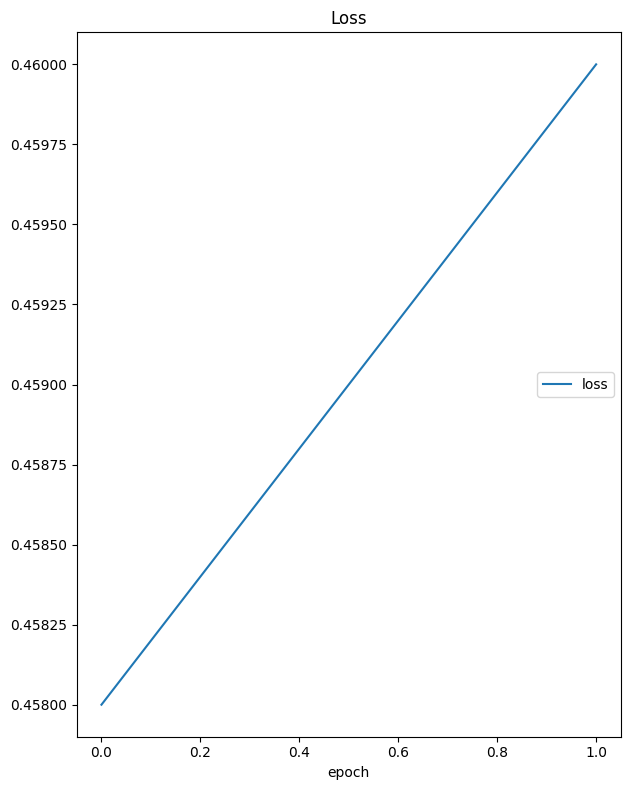

Loss
	loss             	 (min:    0.458, max:    0.460, cur:    0.460)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/Users/croarkin.kyle/Desktop/dial2vec/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/croarkin.kyle/Desktop/dial2vec/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/croarkin.kyle/Desktop/dial2vec/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/croarkin.kyle/Desktop/dial2vec/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Us

AttributeError: 'float' object has no attribute 'purity'

In [ ]:
from livelossplot import PlotLosses
import numpy as np 
from tqdm.notebook import trange, tqdm

plotlosses = PlotLosses()

steps = 0 
d2vmodel.train()

res = EvaluationResult()
for epoch in range(10):
    for step, batch in enumerate(tqdm(train_loader)):
        #batch = tuple(t.to(torch.device("mps")) for t in batch)
        output_dict = d2vmodel(batch, strategy='mean_by_role')
        loss = output_dict['loss']

        loss = loss / 1.0
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if steps % 200 == 0 and steps > 0: 
            new_res = eval(d2vmodel)

            if new_res > res: 
                res = new_res 
                torch.save(model.state_dict(), "best_results_model.pt")
            d2vmodel.train()

        if steps % 100 == 0:
            plotlosses.update({'loss' : np.round(loss.item(), 3)})
            plotlosses.send()            
            torch.save(model.state_dict(), "loss_model.pt")
    


        steps += 1 